In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [13]:
Y_dict = {}
frac_perturb_samples_list = [0.0, 0.8]
frac_perturb_dims_list = [0.1, 0.2, 0.5]

perturb_configs = [(f1, f2) for f1 in frac_perturb_samples_list for f2 in frac_perturb_dims_list]

trials = [11, 12, 13, 14, 15]
n_trials = len(trials)

In [18]:
ell_median = np.load('/home/yz685/saasbo/results/hartmann6_50/median_lengthscales/median_lengthscales_' \
            + '02' + '_' + '05'  + '_' + str(11) + '.npy')
for i in ell_median.argsort()[:6]:
        print(f"Parameter {i:2} Median lengthscale = {ell_median[i]:.2e}")

Parameter 47 Median lengthscale = 2.52e-01
Parameter 23 Median lengthscale = 3.35e-01
Parameter 33 Median lengthscale = 3.57e-01
Parameter  1 Median lengthscale = 4.84e-01
Parameter  7 Median lengthscale = 5.03e-01
Parameter 11 Median lengthscale = 5.09e-01


In [22]:
for frac_perturb_samples_num, frac_perturb_dims_num in perturb_configs:

    frac_perturb_samples = str(frac_perturb_samples_num).replace('.', '')
    frac_perturb_dims = str(frac_perturb_dims_num).replace('.', '')

    Y = None
    for trial in trials:
        y = np.load('/home/yz685/saasbo/results/hartmann6_50/output_at_X/output_at_X_' \
            + frac_perturb_samples + '_' + frac_perturb_dims  + '_' + str(trial) + '.npy')
        y = np.expand_dims(np.minimum.accumulate(y), 0)
        if Y is None:
            Y = y 
        else:
            Y = np.vstack((Y, y))
    
    Y_dict[(frac_perturb_samples_num, frac_perturb_dims_num)] = Y


    ell_median = np.load('/home/yz685/saasbo/results/hartmann6_50/median_lengthscales/median_lengthscales_' \
            + frac_perturb_samples + '_' + frac_perturb_dims  + '_' + str(trial) + '.npy')
    for i in ell_median.argsort()[:6]:
        if i not in [1, 7, 11, 23, 47, 33]:
            print(f'Failed to identify important dimension {i} at {frac_perturb_samples_num} samples perturbed, {frac_perturb_dims_num} dimensions perturbed, trial {trial}')
            # print(f"Parameter {i:2} Median lengthscale = {ell_median[i]:.2e}")

Failed to identify important dimension 17 at 0.0 samples perturbed, 0.2 dimensions perturbed, trial 15
Failed to identify important dimension 38 at 0.0 samples perturbed, 0.2 dimensions perturbed, trial 15
Failed to identify important dimension 30 at 0.0 samples perturbed, 0.2 dimensions perturbed, trial 15
Failed to identify important dimension 29 at 0.0 samples perturbed, 0.2 dimensions perturbed, trial 15
Failed to identify important dimension 22 at 0.8 samples perturbed, 0.1 dimensions perturbed, trial 15
Failed to identify important dimension 4 at 0.8 samples perturbed, 0.2 dimensions perturbed, trial 15
Failed to identify important dimension 36 at 0.8 samples perturbed, 0.2 dimensions perturbed, trial 15


Text(0.5, 1.0, 'Hartmann6 (d=6, D=50)')

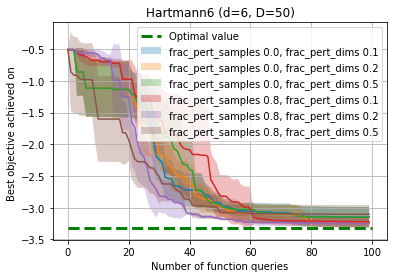

In [16]:
plt.plot([0, 100], [-3.322, -3.322], "--", c="g", lw=3, label="Optimal value")
plt.grid(True)

for frac_perturb_samples_num, frac_perturb_dims_num in Y_dict.keys():

    Y = Y_dict[(frac_perturb_samples_num, frac_perturb_dims_num)]

    plt.plot(np.mean(Y, axis = 0))
    plt.fill_between(
        np.arange(len(Y[0])),
        np.mean(Y, axis = 0) - 2 * np.std(Y, axis=0) / (n_trials ** 0.5),
        np.mean(Y, axis = 0) + 2 * np.std(Y, axis=0) / (n_trials ** 0.5),
        alpha = 0.3, label = 'frac_pert_samples {}, frac_pert_dims {}'.format(frac_perturb_samples_num, frac_perturb_dims_num)
    )

plt.legend()
plt.xlabel('Number of function queries') # seems liike I'm not including the initial ones
plt.ylabel('Best objective achieved on ')
plt.title('Hartmann6 (d=6, D=50)')